### Python Code for Bike-Rental Project

The following libraries are imported to be used in this project.

In [53]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import KNN
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pydotplus as pdp
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO 
import statsmodels.api as sm

To set the working directory, the following statement is used.

In [2]:
os.chdir("C:\\Users\\admin\\Desktop\\Aravi\\Data Science\\Important Notes\\EdWisor\\Assignments\\Project 1 - Bike Rental")

Using the following statement, the data can be loaded from the working directory. 

In [3]:
rental_data = pd.read_csv("Day.csv")

In [4]:
#To check the dimensions of the data
rental_data.shape

(731, 16)

### Missing Value Analysis

In [5]:
#Selected all the variables except instant and cnt and checked for the number of missing values in each variable
missing_val = pd.DataFrame(rental_data.iloc[:,1:15].isnull().sum()) 
missing_val.columns = ["Missing Values"]

In [6]:
missing_val

,Missing Values
dteday,0
season,0
yr,0
mnth,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0
atemp,0


As there are no missing values, we can move on to the next section.

### Outlier Analysis

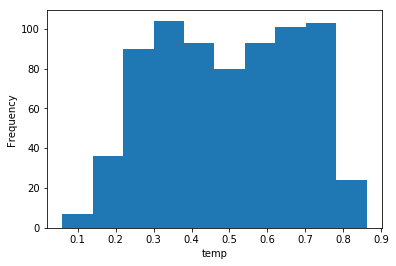

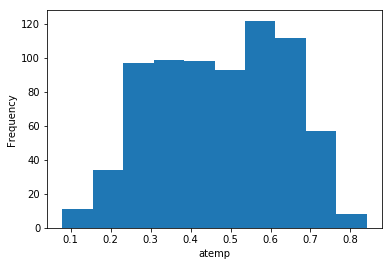

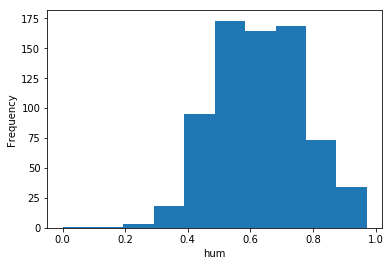

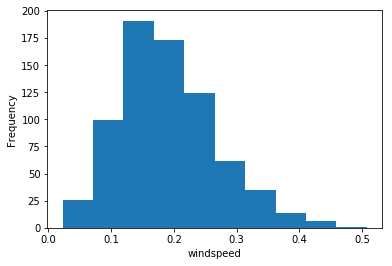

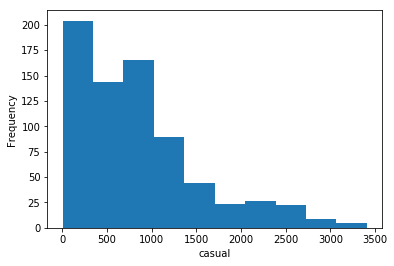

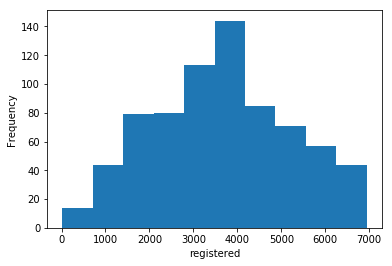

In [7]:
#Creating Histogram to check the data distribution
for i in range(9,15):
    plt.hist(rental_data.iloc[:,i])
    plt.xlabel(rental_data.columns[i])
    plt.ylabel('Frequency')
    plt.show()

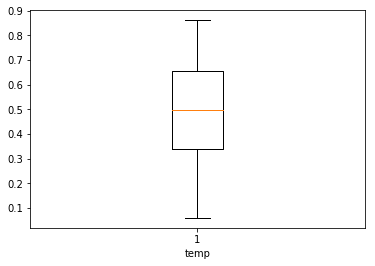

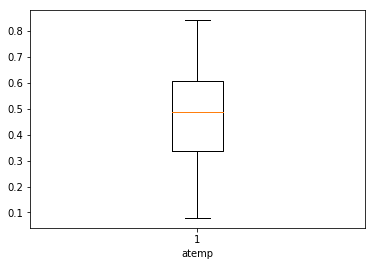

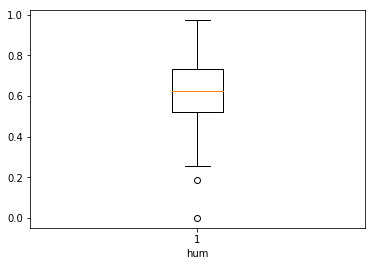

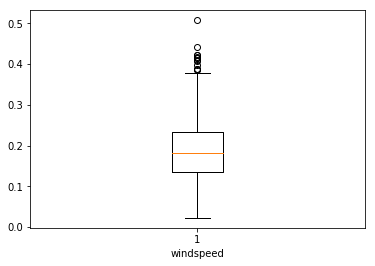

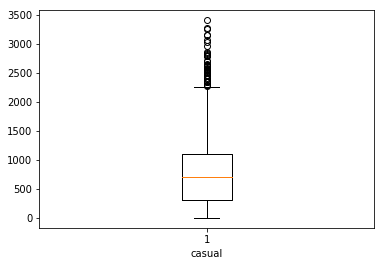

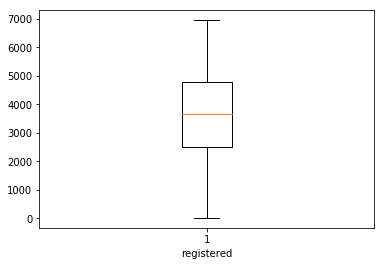

In [8]:
#Creating Box and Whisker plots to check for outliers
for i in range(9,15):
    plt.boxplot(rental_data.iloc[:,i])
    plt.xlabel(rental_data.columns[i])
    plt.show()

Now. we will remove the outliers from 'hum' , 'windspeed' and 'casual' variables and replace them with imputed data using knn imputation method.

In [9]:
#Handling Outliers using KNN Imputation method

#Taking copy of data and initiating the variables to handle

df=rental_data.copy()
cnames = ["hum","windspeed","casual"] 

#Detect outliers and replace with NA

for i in cnames:
    q75, q25 = np.percentile(df.loc[:,i], [75 ,25])
    iqr = q75 - q25
    low = q25 - (iqr*1.5)
    high = q75 + (iqr*1.5)
    df.loc[df[i] < low,i] = np.nan
    df.loc[df[i] > high,i] = np.nan


missing_val = pd.DataFrame(df.loc[:,cnames].isnull().sum())
missing_val.columns = ["Missing Values"] 
missing_val    #displays number of outliers in the three variables

,Missing Values
hum,2
windspeed,13
casual,44


In [10]:
#Imputing the outliers with KNN
df = pd.DataFrame(KNN(k = 3).fit_transform(df.iloc[:,2:15]), columns = df.iloc[:,2:15].columns)

Imputing row 1/731 with 0 missing, elapsed time: 0.435
Imputing row 101/731 with 0 missing, elapsed time: 0.435
Imputing row 201/731 with 0 missing, elapsed time: 0.435
Imputing row 301/731 with 0 missing, elapsed time: 0.435
Imputing row 401/731 with 0 missing, elapsed time: 0.435
Imputing row 501/731 with 0 missing, elapsed time: 0.435
Imputing row 601/731 with 0 missing, elapsed time: 0.435
Imputing row 701/731 with 0 missing, elapsed time: 0.435


In [11]:
#Checking the missing values after KNN imputation
missing_val = pd.DataFrame(df.loc[:,cnames].isnull().sum())
missing_val.columns = ["Missing Values"] 
missing_val    #displays number of outliers in the three variables

,Missing Values
hum,0
windspeed,0
casual,0


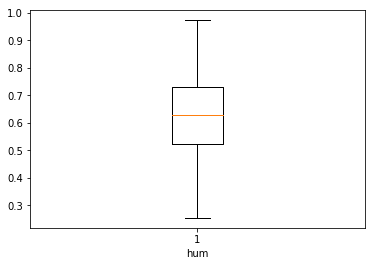

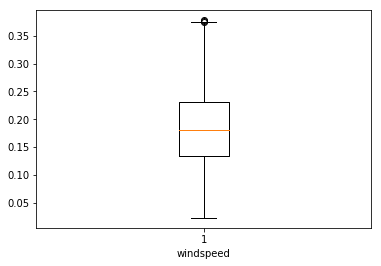

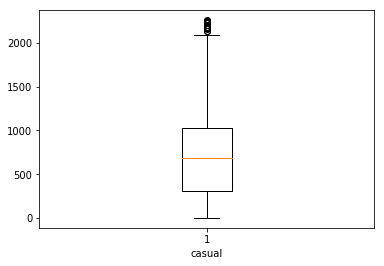

In [12]:
#Creating Box and Whisker plots to check for outliers after outliers are removed
for i in cnames:
    plt.boxplot(df.loc[:,i])
    plt.xlabel(i)
    plt.show()

Here, we can find that, the outliers in 'hum' had been removed and outliers in 'windspeed' and 'casual' have been considerably reduced and brought close to the whiskers of the plot. Hence these outliers are not again treated and they are considered as part of data as they wont bias the model. Now, the variable 'cnt' is also changed based on values of 'casual' and 'registered'.

In [13]:
df['cnt']=df['casual']+df['registered']
rental_data = pd.concat([rental_data.iloc[:,0:2].reset_index(drop=True),df],axis = 1) #Rental data dataset is again formed

Now, outliers have been efficiently handled and we can move on to the next preprocessing technique

### Feature Selection

Correlation analysis for forming the heatmap based on correlation matrix

In [14]:
#Formation of Correlation Matrix

cor = rental_data.iloc[:,2:].corr()
cor

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.193809,-0.209264,0.256593,0.411623,0.420198
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.123781,-0.024217,0.182858,0.594248,0.554302
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.213788,-0.192474,0.160132,0.293488,0.293236
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.018140,0.016050,0.032637,-0.108745,-0.082997
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.044932,0.009568,0.011974,0.057367,0.051927
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.026835,-0.014032,-0.389079,0.303907,0.148858
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.624750,0.061658,-0.274246,-0.260388,-0.297034
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.122745,-0.144679,0.582635,0.540012,0.619885
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.136351,-0.170753,0.582034,0.544192,0.623257
hum,0.193809,-0.123781,0.213788,-0.018140,-0.044932,0.026835,0.624750,0.122745,0.136351,1.000000,-0.205390,-0.081447,-0.113946,-0.119225


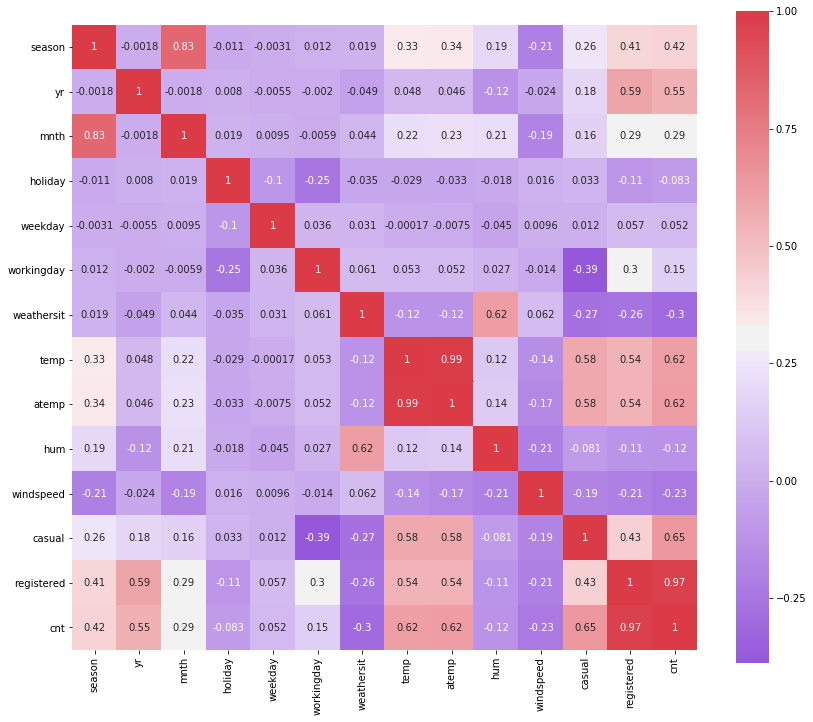

In [15]:
#Fixing the figure size and generating heatmap

f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cor,square=True,annot=True,cmap=sns.diverging_palette(1000, 10, as_cmap=True), ax=ax)

From the heatmap, we can come to the conclusion that the variables 'holiday', 'weekday', 'hum', 'windspeed', 'mnth' and 'atemp'
can be removed as part of feature selection to reduce overfitting and remove the less important variables.

In [16]:
rental_data = rental_data.drop(['instant','dteday','holiday', 'weekday', 'hum', 'windspeed', 'mnth','atemp'],axis=1)

### Feature Scaling

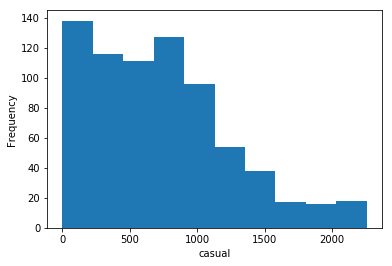

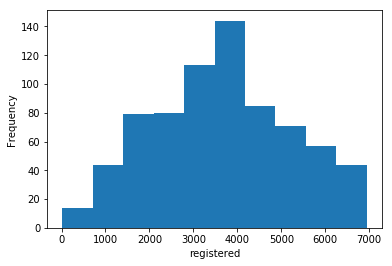

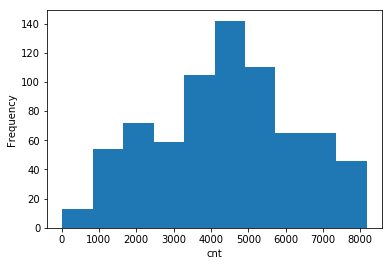

   season   yr  workingday  weathersit      temp    casual  registered  \
0     1.0  0.0         0.0         2.0  0.344167  0.145833    0.091539   
1     1.0  0.0         0.0         2.0  0.363478  0.057181    0.093849   
2     1.0  0.0         1.0         1.0  0.196364  0.052305    0.174560   
3     1.0  0.0         1.0         1.0  0.200000  0.046986    0.207046   
4     1.0  0.0         1.0         1.0  0.226957  0.035461    0.216286   

        cnt  
0  0.118145  
1  0.095571  
2  0.162802  
3  0.188934  
4  0.193596  


In [17]:
#Dependent Variables casual, registered and cnt are also normalised as it will be esier for evaluation of model
#They are normalised as all data are not ubiformly distributed
norm_var = ["casual","registered","cnt"]
for i in norm_var:
    plt.hist(rental_data[i])
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.show()
    rental_data[i] = (rental_data[i] - min(rental_data[i]))/(max(rental_data[i]) - min(rental_data[i]))
print(rental_data.head(5))

Now the data is completely Normalised and the basic pre processing is completed and the dataset is ready for the Modelling phase.

### Modeling

#### Error Metric
In this project, we are going to use MAPE and RMSE as the error metrics to measure the performance of the model

In [18]:
#Defining MAPE and RMSE
def MAPE(actual, predicted):
    result = 100*np.mean(np.abs((actual-predicted)/actual))
    return result

def RMSE(actual, predicted):
    result = (np.mean((actual-predicted)**2))**0.5
    return result

#### Decision Tree
The first model is  the decision tree

In [89]:
#Sampling the data for training and testing purposes
train_data, test_data = train_test_split(rental_data, test_size=0.2)

In [20]:
#Model generaion based on training data
casual_model = DecisionTreeRegressor(max_depth = 5).fit(train_data.iloc[:,0:5],train_data.iloc[:,5])
registered_model = DecisionTreeRegressor(max_depth = 5).fit(train_data.iloc[:,0:5],train_data.iloc[:,6])
cnt_model = DecisionTreeRegressor(max_depth = 5).fit(train_data.iloc[:,0:5],train_data.iloc[:,7])

In [21]:
#Getting the model predict the target variable based on test data
casual_predictions = casual_model.predict(test_data.iloc[:,0:5])
registered_predictions = registered_model.predict(test_data.iloc[:,0:5])
cnt_predictions = cnt_model.predict(test_data.iloc[:,0:5])

In [22]:
#Evaluating the model
print("MAPE")
print("Casual - " + str(MAPE(test_data.iloc[:,5],casual_predictions)))
print("Registered - " + str(MAPE(test_data.iloc[:,6],registered_predictions)))
print("Cnt - " + str(MAPE(test_data.iloc[:,7],cnt_predictions)))
print("RMSE")
print("Casual - " + str(RMSE(test_data.iloc[:,5],casual_predictions)))
print("Registered - " + str(RMSE(test_data.iloc[:,6],registered_predictions)))
print("Cnt - " + str(RMSE(test_data.iloc[:,7],cnt_predictions)))

MAPE
Casual - 48.81357644542093
Registered - 22.42690593083405
Cnt - 20.312685852589873
RMSE
Casual - 0.14689939052881815
Registered - 0.12027895252184015
Cnt - 0.11229041865121038


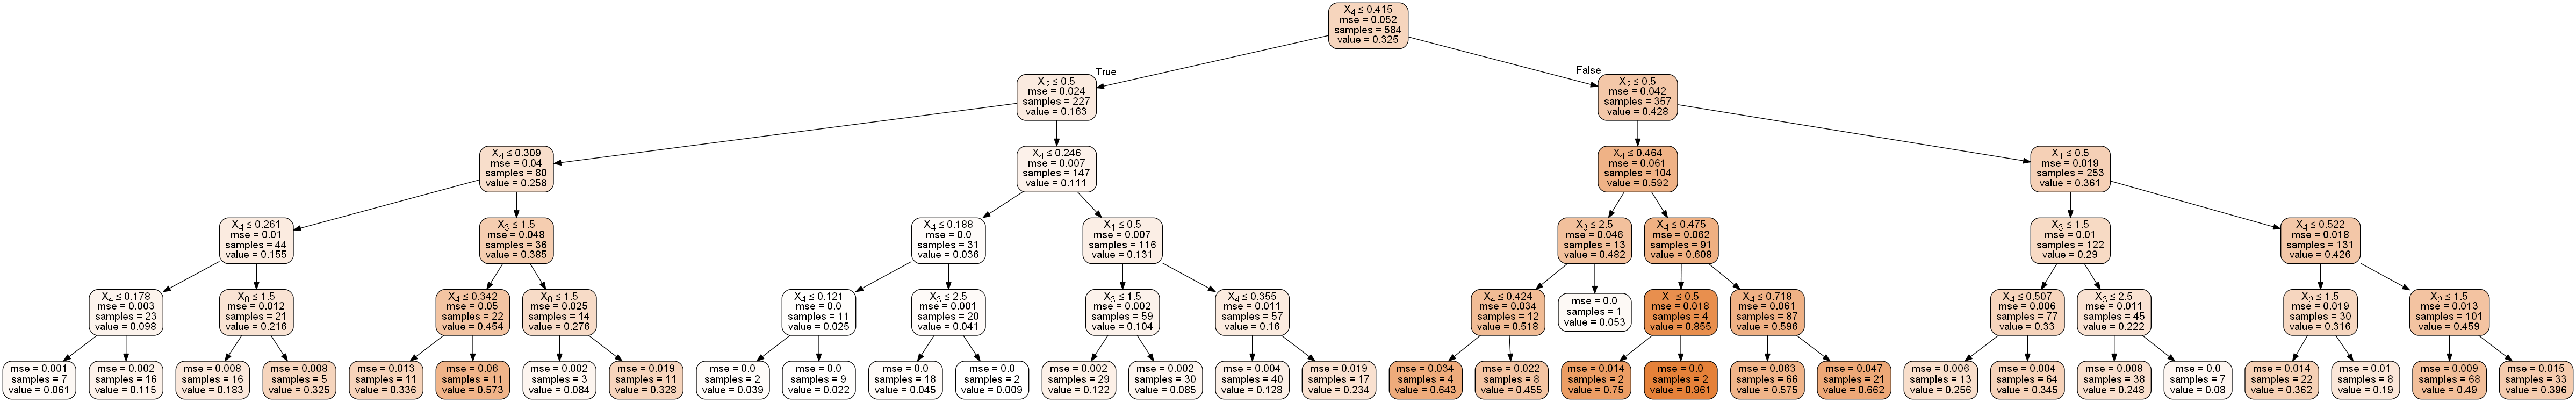

In [25]:
#To visualise a decision tree
dot_data = StringIO()
export_graphviz(casual_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pdp.graph_from_dot_data(dot_data.getvalue())  
graph.write_png("DT.png") #The decision tree is exported to the directory as png file
Image(graph.create_png())

#### Random Forest
The next model is the Random Forest.

In [90]:
#We can use the same train and test data that we used for decision trees
#Model generation
casual_model = RandomForestRegressor(n_estimators = 10).fit(train_data.iloc[:,0:5],train_data.iloc[:,5])
registered_model = RandomForestRegressor(n_estimators = 10).fit(train_data.iloc[:,0:5],train_data.iloc[:,6])
cnt_model = RandomForestRegressor(n_estimators = 10).fit(train_data.iloc[:,0:5],train_data.iloc[:,7])

In [91]:
#Getting the model predict the target variable based on test data
casual_predictions = casual_model.predict(test_data.iloc[:,0:5])
registered_predictions = registered_model.predict(test_data.iloc[:,0:5])
cnt_predictions = cnt_model.predict(test_data.iloc[:,0:5])

In [92]:
#Evaluating the model
print("MAPE")
print("Casual - " + str(MAPE(test_data.iloc[:,5],casual_predictions)))
print("Registered - " + str(MAPE(test_data.iloc[:,6],registered_predictions)))
print("Cnt - " + str(MAPE(test_data.iloc[:,7],cnt_predictions)))
print("RMSE")
print("Casual - " + str(RMSE(test_data.iloc[:,5],casual_predictions)))
print("Registered - " + str(RMSE(test_data.iloc[:,6],registered_predictions)))
print("Cnt - " + str(RMSE(test_data.iloc[:,7],cnt_predictions)))

MAPE
Casual - 53.01155298068071
Registered - 21.53409316436001
Cnt - 20.380874591608087
RMSE
Casual - 0.14574557460469276
Registered - 0.09529630282069902
Cnt - 0.0928531224207044


### Linear Regression
The next model is the Linear Regression

In [75]:
casual_model = sm.OLS(train_data.iloc[:,5],train_data.iloc[:,0:5]).fit()
registered_model = sm.OLS(train_data.iloc[:,6],train_data.iloc[:,0:5]).fit()
cnt_model = sm.OLS(train_data.iloc[:,7],train_data.iloc[:,0:5]).fit()

In [76]:
casual_predictions = casual_model.predict(test_data.iloc[:,0:5])
registered_predictions = registered_model.predict(test_data.iloc[:,0:5])
cnt_predictions = cnt_model.predict(test_data.iloc[:,0:5])

In [77]:
#Evaluating the model
print("MAPE")
print("Casual - " + str(MAPE(test_data.iloc[:,5],casual_predictions)))
print("Registered - " + str(MAPE(test_data.iloc[:,6],registered_predictions)))
print("Cnt - " + str(MAPE(test_data.iloc[:,7],cnt_predictions)))
print("RMSE")
print("Casual - " + str(RMSE(test_data.iloc[:,5],casual_predictions)))
print("Registered - " + str(RMSE(test_data.iloc[:,6],registered_predictions)))
print("Cnt - " + str(RMSE(test_data.iloc[:,7],cnt_predictions)))

MAPE
Casual - 65.02613561697862
Registered - 21.23683334237258
Cnt - 22.720081671830826
RMSE
Casual - 0.15812334399529426
Registered - 0.08875489435017742
Cnt - 0.10418189613032994


In [79]:
#Model Summary of cnt model
cnt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     3253.
Date:                Wed, 29 May 2019   Prob (F-statistic):               0.00
Time:                        22:30:36   Log-Likelihood:                 471.29
No. Observations:                 584   AIC:                            -932.6
Df Residuals:                     579   BIC:                            -910.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         0.0588      0.004     14.260      0.000       0.051       0.067
yr             0.2417      0.009     27.440      0.000       0.224       0.259
workingday     0.0784      0.009      8.280      0.000       0.060       0.097
weathersit    -0.0766      0.007    -11.561      0.000      -0.090      -0.064
temp           0.6418      0.023     28.270      0.000       0.597       0.686
==============================================================================
Omnibus:                      100.282   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.385
Skew:                          -0.921   Prob(JB):                     1.89e-49
Kurtosis:                       5.415   Cond. No.                         16.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

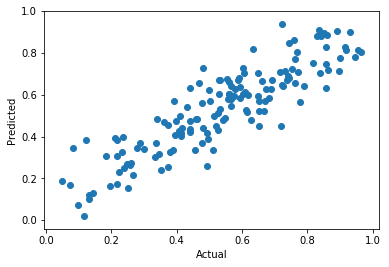

In [83]:
#Scatter plot to visualise cnt variable predictions
plt.scatter(test_data.iloc[:,7],cnt_predictions)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

Based on the error metrics of these three models, Random Forest is the best model for this data. Hence we will use it to predict output.

### Output
Using Random Forest model, let us give in a sample input to the model to get the sample predicted output.

In [93]:
#Sample input of 5 rows is fetched from the dataset
sample_input = rental_data.iloc[[99,199,299,399,499],:]

#Random Forest model is built using the complete dataset
casual_model = RandomForestRegressor(n_estimators = 10).fit(rental_data.iloc[:,0:5],rental_data.iloc[:,5])
registered_model = RandomForestRegressor(n_estimators = 10).fit(rental_data.iloc[:,0:5],rental_data.iloc[:,6])
cnt_model = RandomForestRegressor(n_estimators = 10).fit(rental_data.iloc[:,0:5],rental_data.iloc[:,7])

#Using these models the dependent variables are predicted for the sample_input
casual_predictions = casual_model.predict(sample_input.iloc[:,0:5])
registered_predictions = registered_model.predict(sample_input.iloc[:,0:5])
cnt_predictions = cnt_model.predict(sample_input.iloc[:,0:5])

In [100]:
#Output dataframe is created and it is stored in csv file and exported
sample_output = pd.concat([sample_input.reset_index(drop=True), \
    pd.DataFrame({'casual_pd':casual_predictions,'registered_pd':registered_predictions,'cnt_pd':cnt_predictions})],axis = 1)
sample_output.to_csv("Python Sample Output.csv",index=False)
sample_output

,season,yr,workingday,weathersit,temp,casual,registered,cnt,casual_pd,registered_pd,cnt_pd
0,2.0,0.0,0.0,2.0,0.426667,0.525709,0.243575,0.352472,0.474158,0.259500,0.329444
1,3.0,0.0,1.0,1.0,0.776667,0.332447,0.544181,0.554411,0.341829,0.541597,0.554417
2,4.0,0.0,1.0,2.0,0.470000,0.105496,0.346376,0.323519,0.144947,0.399653,0.390222
3,1.0,1.0,0.0,2.0,0.264167,0.169326,0.350563,0.344743,0.168440,0.342478,0.327862
4,2.0,1.0,1.0,2.0,0.573333,0.150709,0.358215,0.346093,0.239184,0.427346,0.465734


### Interesting Patterns
Additionally, let us see some interesting patterns for getting certain insights on the data

In [102]:
#The original data is fetched once again to check patterns
rental_data = pd.read_csv("Day.csv")

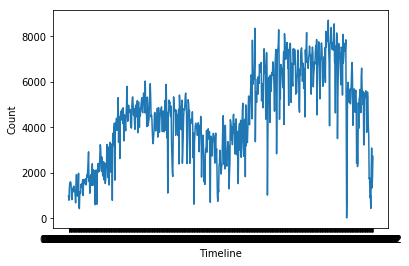

In [104]:
plt.plot(rental_data["dteday"],rental_data["cnt"])
plt.xlabel("Timeline")
plt.ylabel("Count")
plt.show()

The plot between timeline and count shows that during the mid-years i.e., (Apr-Sep) the count of rental bikes increase and in the beginning and end of the years, they decrease.

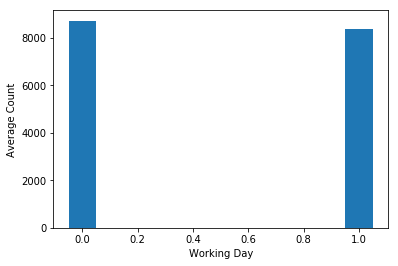

In [115]:
plt.bar(rental_data["workingday"],rental_data["cnt"],width=0.1)
plt.xlabel("Working Day")
plt.ylabel("Average Count")
plt.show()

Based on this Bar Chart, there is no significant difference in total rental bikes used by customers on workingdays and weekends 

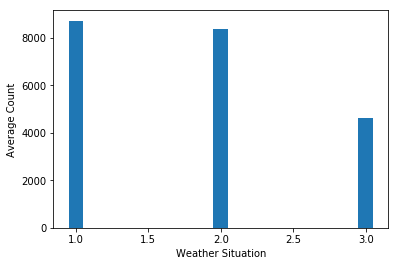

In [116]:
plt.bar(rental_data["weathersit"],rental_data["cnt"], width=0.1)
plt.xlabel("Weather Situation")
plt.ylabel("Average Count")
plt.show()

This Barchart shows that during weather situation 3 (Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds), the total rented bikes has become nearly half than the normal days. So during rainy days, the count of bikes rented will be reduced.

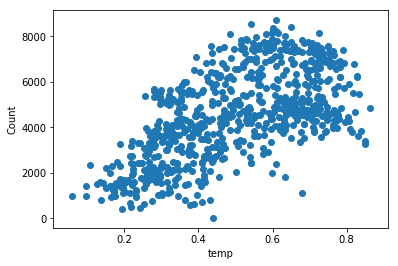

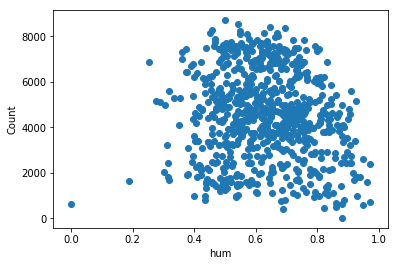

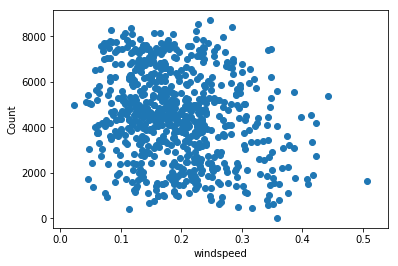

In [113]:
for i in ["temp","hum","windspeed"]:
    plt.scatter(rental_data[i],rental_data["cnt"])
    plt.xlabel(i)
    plt.ylabel("Count")
    plt.show()

The relationship between Temperature and Count shows that during hotter days, the count of rented bikes is higher when compared to colder days. But the other two scatter plots show that the count o rental bikes is not related to 'hum' and 'windspeed' variables as data is randomly scattered in these plots.

Thus we have analysed the data, built a model and predicted the count of rental bikes based on environmental and seasonal settings.